In [1]:
#!/usr/bin/env python

# 2020_XWTs-IFS.ipynb

#!/usr/bin/env python
'''File name: 2020_XWTs-IFS.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.05.2020
    Date last modified: 04.05.2020

    ############################################################## 
    Purpos:

    Load XWTs centroids that were created by running:
    /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/XWTing/XWTs_search_ERA5.py

    1) Read the nescessary variables from the model in which XWTs should be searched for
    2) Bring the centroids and the model data to the common coarser resolution grid
    3) Preprocess the model data
    3) Calculate Eucledian Distances for each day
    4) Save the data
    
    5) Read in the biggest 2020 fire day conditions from IFS
    6) Plot those conditions including the fals alarm rate score
       to indicate if this is a nown XWT or a new one

'''

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import EucledianDistance

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)




### Program Setup

In [102]:
Season='Annual' # ['AMJJAS', 'ONDJFM']

DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/' #+Regions[sRegion]

DW_RegionsSORTING=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']
SortXWTs = [[0,1],
           [2,0,1],
           [0,1],
           [1,0],
           [3,0,2,1], #[2,1,0],
           [0,1],
           [1,0,2],
           [2,1,0]]
smoothing_radius = 0.5

Focus_RE = 0
iSORTreg = DW_RegionsSORTING.index(DW_Regions[Focus_RE])

SelVar = np.array([['RH2AVG','MF2AVG','V850'],
         ['RH2AVG','SLPAVG','WSPD10'],
         ['MR2AVG','SLPAVG','WSPD10'],
         ['T2MIN','WSPD10','Z500'],
         ['RH2AVG','RH500','U200'],
         ['MF2AVG','PWAVG','V200'],
         ['RH500','T2MIN','V200'],
         ['RH2AVG','V500','WSPD200']])



E5Vars=['CAPE','CIN','LCL','LFC','MF2AVG','MF500','MF850','MR2AVG','MR500','MR850','PWAVG','RH2AVG',\
        'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10AVG','U200','U500','U850',\
        'V10AVG','V200','V500','V850','WSPD10','WSPD200','WSPD500','WSPD850','Z500']
IFSVars = ['CAPE','CIN','LCL','LFC','MF2AVG','FLX500','FLX850','Q2','Q500','Q850','PWAVG','RH2',\
           'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10','U200','U500','U850',\
           'V10','V200','V500','V850','UV10','UV200','UV500','UV850','Z500']



sPlotDir='/glade/u/home/prein/papers/Extreme-WTs-US/plots/IFS_XWTs/'# +str(iNrOfExtremes)+'_Events/'
sDataDir='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_IFS/'

Nr_XWTs = [4,6,10,8,10,4,10,8]

YYYY_stamp = '2001-2019'
Season = 'Annual'
FireObs = 'MODIS'
REANAL = 'ERA5'


# ---------
# Setup clustering algorithm
ClusterMeth='hdbscan'  # current options are ['HandK','hdbscan']
ClusterBreakup = 0     # breakes up clusters that are unproportionally large (only for hdbscan)
RelAnnom=1             # 1 - calculates daily relative anomalies
NormalizeData='D'      # normalize variables | options are  - 'C' - climatology
                                                        # - 'D' - daily (default)
                                                        # - 'N' - none
MinDistDD=7            # minimum nr of days between XWT events
RemoveAnnualCycl=1     # remove annual cycle in varaiables with 21 day moving average filter
# ---------

In [103]:
Season='Annual' # ['AMJJAS', 'ONDJFM']
# Read IFS
dStartDayIFS=datetime.datetime(2016, 1, 1,0)
dStopDayIFS=datetime.datetime(2020, 11, 30,23)
IFS_time = pd.date_range(dStartDayIFS, end=dStopDayIFS, freq='d')
IFS_timeMM = pd.date_range(dStartDayIFS, end=dStopDayIFS, freq='m')
IFSYYYY=np.unique(IFS_time.year)

RE=Focus_RE
Data_All={}
for re in [RE]: #range(len(DW_Regions)):
    Region=DW_Regions[re]
    print('    process '+Region)

    Variables=SelVar[re,:]
    ExtrNR = Nr_XWTs[re]
        
    s = "-"; VarString=s.join(Variables)
    iNrOfExtremes = ExtrNR
    s = "-"; VarString=s.join(Variables)
    VarsJoint = VarString
    
    XWTdata='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/AUC-APR/'+'Clusters'+str(iNrOfExtremes)+'_'+Region+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season+'_'+\
    FireObs+'_'+REANAL+'_'+ClusterMeth+'_Breakup-'+str(ClusterBreakup)+'_RelAnnom-'+str(RelAnnom)+'_Norm-'+NormalizeData+\
    '_DDdist-'+str(MinDistDD)+'_RemAnnCyc-'+str(RemoveAnnualCycl)
    sClusterSave=sDataDir+'Clusters'+str(ExtrNR)+'_'+Region+'_'+YYYY_stamp+'_'+VarString+'_'+Season+'_'+FireObs+'_'+REANAL
    
    # ### Load the centroids and shape file
    print('    Restore: '+XWTdata)
    with open(XWTdata, 'rb') as handle:
        npzfile = pickle.load(handle)
    XWTclusters=npzfile['grClustersFin']['Full']
    XWTlat=npzfile['LatWT']
    XWTlon=npzfile['LonWT']
    XWTtime=npzfile['rgdTime']
    SpatialSmoothing=npzfile['SpatialSmoothing']
    
    print('        Load shapefile')
    sf = shp.Reader(sSubregionPR+Region)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
    
    # ### Read IFS data
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/IFS/T2AVG/T2AVG_201601_daymean.nc', mode='r')
    IFSLat=np.squeeze(ncid.variables['latitude'][:])
    IFSLon=np.squeeze(ncid.variables['longitude'][:])
    ncid.close()
    IFSLon[IFSLon>180]=IFSLon[IFSLon>180]-360
    IFSLon2D, IFSLat2D = np.meshgrid(IFSLon, IFSLat)
    
#     rgrGridCells=[(IFSLon2D.ravel()[ii],IFSLat2D.ravel()[ii]) for ii in range(len(IFSLat2D.ravel()))]
#     rgrSRactP=np.zeros((IFSLat2D.shape[0]*IFSLat2D.shape[1]))
#     TMP=np.array(grPRregion.contains_points(rgrGridCells))
#     rgrSRactP[TMP == 1]=1
#     rgrSRactP=np.reshape(rgrSRactP, (IFSLat2D.shape[0], IFSLat2D.shape[1]))
    
    # get grid cells that cover the centroid
    N_XWT=np.max(XWTlat)
    S_XWT=np.min(XWTlat)
    E_XWT=np.max(XWTlon)
    W_XWT=np.min(XWTlon)
    
    
    # ### Bring data to same grid
    if XWTlat.shape[0]*XWTlon.shape[0] > IFSLat2D.shape[0]*IFSLat2D.shape[1]:
        # we remap the centroids to the model grid
        
        # ERA-20C area that contains this region
        IFS_W=np.where(np.max((IFSLon2D <= W_XWT), axis=0) == 1)[0][-1]+1 #-1
        IFS_E=np.where(np.max((IFSLon2D <= E_XWT), axis=0) == 1)[0][-1]+1
        IFS_S=np.where(np.max((IFSLat2D <= S_XWT), axis=1) == 1)[0][0]-1
        IFS_N=np.where(np.max((IFSLat2D <= N_XWT), axis=1) == 1)[0][0] #-1

        # # Cut out Lat and Lon
        IFSLon2D=IFSLon2D[IFS_N:IFS_S,IFS_W:IFS_E]
        IFSLat2D=IFSLat2D[IFS_N:IFS_S,IFS_W:IFS_E]
        Clusters=np.reshape(XWTclusters[0],(XWTclusters[0].shape[0],XWTlat.shape[0],XWTlon.shape[1],len(Variables)))
        RemappedClusters=np.zeros((Clusters.shape[0],IFSLat2D.shape[0],IFSLat2D.shape[1],Clusters.shape[3]))
        
        [Y,X]=(XWTlon, XWTlat)
        [Yi,Xi]=(IFSLon2D,IFSLat2D)
        xy=np.zeros([X.shape[0]*X.shape[1],2])
        xy[:,0]=Y.flatten()
        xy[:,1]=X.flatten()
        uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
        uv[:,0]=Yi.flatten()
        uv[:,1]=Xi.flatten()
        #Computed once and for all !
        vtx, wts = interp_weights(xy, uv)
        
        for cl in range(Clusters.shape[0]):
            for va in range(len(Variables)):
                values=Clusters[cl,:,:,va]
                valuesi=interpolate(values.flatten(), vtx, wts)
                RemappedClusters[cl,:,:,va]=valuesi.reshape(Xi.shape[0],Xi.shape[1])
        # we have to renormalize the clusters
        Normalized=(RemappedClusters-np.mean(RemappedClusters, axis=(1,2))[:,None,None,:])
        Normalized=Normalized/np.std(Normalized, axis=(1,2))[:,None,None,:]
        ClusterPrepared=(np.reshape(Normalized, (Normalized.shape[0],Normalized.shape[1]*Normalized.shape[2]*Normalized.shape[3])),XWTclusters[1])
    else:
        # we remap the data to the resolution of the centroids
        # ERA-20C area that contains this region
        IFS_W=np.where(np.max((IFSLon2D <= W_XWT), axis=0) == 1)[0][-1]-10 #-1
        IFS_E=np.where(np.max((IFSLon2D <= E_XWT), axis=0) == 1)[0][-1]+10
        IFS_S=np.where(np.max((IFSLat2D <= S_XWT), axis=1) == 1)[0][0]+10
        IFS_N=np.where(np.max((IFSLat2D <= N_XWT), axis=1) == 1)[0][0]-10 #-1

        # # Cut out Lat and Lon
        IFSLon2D=IFSLon2D[IFS_N:IFS_S,IFS_W:IFS_E]
        IFSLat2D=IFSLat2D[IFS_N:IFS_S,IFS_W:IFS_E]
    
    IFS_DATA=np.zeros((len(IFS_time),IFSLon2D.shape[0],IFSLon2D.shape[1], len(Variables))); IFS_DATA[:]=np.nan
    for mm in range(len(IFS_timeMM)):
        DDact=((IFS_time.year == IFS_timeMM[mm].year) & (IFS_time.month == IFS_timeMM[mm].month))
        for va in range(len(Variables)):
            VARact = IFSVars[E5Vars.index(Variables[va])]
            FILE=glob.glob('/glade/campaign/mmm/c3we/prein/IFS/'+VARact+'/'+VARact+'_'+str(IFS_timeMM[mm].year)+str(IFS_timeMM[mm].month).zfill(2)+'_daymean.nc')[0]
            ncid=Dataset(FILE, mode='r') # open the netcdf file
            IFS_DATA[DDact,:,:,va]=np.squeeze(ncid.variables[VARact][:,IFS_N:IFS_S,IFS_W:IFS_E])
            ncid.close()

    # smooth the data
    SmoothSigma = 2
    IFS_DATASM = gaussian_filter(IFS_DATA[:,:,:,:], sigma=(0,SmoothSigma,SmoothSigma,0))

    if XWTlat.shape[0]*XWTlon.shape[0] <= IFSLat2D.shape[0]*IFSLat2D.shape[1]:
        # we remap the data to the resolution of the centroids
        Clusters=np.reshape(XWTclusters[0],(XWTclusters[0].shape[0],XWTlat.shape[0],XWTlon.shape[1],len(Variables)))
        RemappedIFS=np.zeros((IFS_DATA.shape[0],XWTlat.shape[0],XWTlon.shape[1],IFS_DATA.shape[3]))
        
        [Y,X]=(IFSLon2D,IFSLat2D)
        [Yi,Xi]=(XWTlon, XWTlat)
        xy=np.zeros([X.shape[0]*X.shape[1],2])
        xy[:,0]=Y.flatten()
        xy[:,1]=X.flatten()
        uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
        uv[:,0]=Yi.flatten()
        uv[:,1]=Xi.flatten()
        #Computed once and for all !
        vtx, wts = interp_weights(xy, uv)
        
        for dd in range(IFS_DATA.shape[0]):
            for va in range(IFS_DATA.shape[3]):
                values=IFS_DATASM[dd,:,:,va]
                valuesi=interpolate(values.flatten(), vtx, wts)
                RemappedIFS[dd,:,:,va]=valuesi.reshape(Xi.shape[0],Xi.shape[1])
        # prepare the existing clusters
        if len(XWTclusters) == 3:
            # search clusters on centroids and individual XWT days
            XWTclusters = list(XWTclusters)
            XWTclusters[0] = np.append(XWTclusters[0],np.reshape(XWTclusters[2], (XWTclusters[2].shape[0],XWTclusters[2].shape[1]*XWTclusters[2].shape[2]*XWTclusters[2].shape[3])), axis=0)
            XWTclusters[1] = np.append(np.array(range(np.max(XWTclusters[1]+1))),XWTclusters[1])
            ClusterPrepared = XWTclusters
        else:
            ClusterPrepared=(np.reshape(Clusters, (Clusters.shape[0],Clusters.shape[1]*Clusters.shape[2]*Clusters.shape[3])),Clusters[1])

    DailyVarsEvalNorm=PreprocessWTdata(RemappedIFS,                  # WT data [time,lat,lon,var]
                               RelAnnom=RelAnnom,                     # calculate relative anomalies [1-yes; 0-no]
                               SmoothSigma=smoothing_radius,   # Smoothing stddev (Gaussian smoothing)
                               RemoveAnnualCycl=RemoveAnnualCycl,             # remove annual cycle [1-yes; 0-no]
                               NormalizeData=NormalizeData)                # normalize data [1-yes; 0-no]

    EucledianDist, Correlation =EucledianDistance(DailyVarsEvalNorm,
                                                  ClusterPrepared)
    EucledianDist_orig=np.copy(EucledianDist)
#     EucledianDist=np.min(EucledianDist,axis=1)
    ArgMIN = np.argmin(EucledianDist, axis=1)
    EucledianDist = np.array([EucledianDist[ii][ArgMIN[ii]] for ii in range(EucledianDist.shape[0])])

    EDspace=np.linspace(EucledianDist.min(),np.percentile(EucledianDist,0.2),100)
#     ChangeInFr=np.zeros((len(EDspace)))
#     RP=np.zeros((len(EDspace)))
#     ClimLen=40

#     for ed in range(len(EDspace)):
#         TEST=(EucledianDist < EDspace[ed])
#         ExtrFrY=float(np.sum(TEST))/len(IFSYYYY)
#         ExpectedFrequency=np.cumsum(np.array([ExtrFrY]*len(IFSYYYY)))
#         RP[ed]=ExtrFrY
#         TEST=np.array([np.sum(TEST[IFS_time.year == IFSYYYY[yy]]) for yy in range(len(IFSYYYY))])
#         TEST=np.cumsum(TEST, dtype=float)
    
#         Ref=(TEST[ClimLen]-TEST[0])
#         Cur=(TEST[-1]-TEST[-ClimLen])
#         ChangeInFr[ed]=((Cur-Ref)/float(Ref))*100

#     # In[37]:
#     # calculate random chance
#     try:
#         RandomChance
#     except:
#         BSnr=1000
#         RandomChance=np.zeros((len(RP),BSnr))
#         for pe in range(len(RP)):
#             NrOfEvents=(RP*len(IFSYYYY))[pe]
#             for bs in range(BSnr):
#                 RandomDays=np.sort(np.array([random.randint(0, len(IFSYYYY)-1) for ii in range(int(NrOfEvents))]))
#                 RandRecord=np.zeros((len(IFSYYYY)))
#                 for ii in range(len(RandomDays)):
#                     RandRecord[RandomDays[ii]]=RandRecord[RandomDays[ii]]+1
#                 Ref=np.sum(RandRecord[:ClimLen])
#                 Cur=np.sum(RandRecord[-ClimLen:])
#                 RandomChance[pe,bs]=((Cur-Ref)/float(Ref))*100

    Data_reg={'EucledianDist_orig':EucledianDist_orig,
              'IFS_time':IFS_time}
    Data_All[Region]=Data_reg

# Save the data
afile = open(sDataDir+'IFS_XWTs_Eucledian-Distances.pkl', 'wb')
pickle.dump(Data_All, afile)
afile.close()

# Load the Eulirian distance data
file = open(sDataDir+'IFS_XWTs_Eucledian-Distances.pkl', 'rb')
DATA_ED = pickle.load(file)
file.close()

EucledianDist_orig = DATA_ED[DW_Regions[Focus_RE]]['EucledianDist_orig']

    process Bay_Area
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/AUC-APR/Clusters4_Bay_Area_2001-2019_RH2AVG-MF2AVG-V850_Annual_MODIS_ERA5_hdbscan_Breakup-0_RelAnnom-1_Norm-D_DDdist-7_RemAnnCyc-1
        Load shapefile


### Save the patterns to compare to NOAA 20C reanalysis

In [104]:
np.savez(sDataDir+'IFS_patterns_'+DW_Regions[Focus_RE]+'.npz',
       DailyVarsEvalNorm = DailyVarsEvalNorm,
       IFSLon2D=IFSLon2D,
       IFSLat2D=IFSLat2D,
       IFS_time=IFS_time)

### Load VIIRS data

In [105]:
Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_archive_V1_7669.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_nrt_V1_7669.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/TMP/fire_nrt_J1V-C2_10961.csv'

# Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/200011-202011/fire_nrt_J1V-C2_171399.csv'

dStartDayPR=datetime.datetime(2016, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2020, 11, 30,23)
rgdTimeFIRMS_V = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

DATA1 = pd.read_csv(Data1)
DATA2 = pd.read_csv(Data2)

LAT_FV = np.append(np.array(DATA1['latitude']),np.array(DATA2['latitude']))
LON_FV = np.append(np.array(DATA1['longitude']),np.array(DATA2['longitude']))
DATE_FV = np.append(np.array(DATA1['acq_date']),np.array(DATA2['acq_date']))
AREA_FV = np.append(np.array(DATA1['scan'])*np.array(DATA1['track']),np.array(DATA2['scan'])*np.array(DATA2['track']))

# DATA1 = pd.read_csv(Data1)
# LAT_FV = np.array(DATA1['latitude'])
# LON_FV = np.array(DATA1['longitude'])
# DATE_FV = np.array(DATA1['acq_date'])
# AREA_FV = np.array(DATA1['scan'])*np.array(DATA1['track'])

# Cut out CA region
CA = ((LAT_FV >= 32) & (LAT_FV <= 42) & (LON_FV >= -125) & (LON_FV <=- 114))
LAT_FV = LAT_FV[CA]
LON_FV = LON_FV[CA]
DATE_FV = DATE_FV[CA]
AREA_FV = AREA_FV[CA]

YYYY_FV = np.array([int(DATE_FV[ii][:4]) for ii in range(len(DATE_FV))])
MM_FV = np.array([int(DATE_FV[ii][5:7]) for ii in range(len(DATE_FV))])
DD_FV = np.array([int(DATE_FV[ii][8:10]) for ii in range(len(DATE_FV))])

FIRMSV_SRdata=np.zeros((len(rgdTimeFIRMS_V))); FIRMSV_SRdata[:]=0
for sr in [Focus_RE]: #range(len(DW_Regions)):
    print('    process VIIRS data for region '+DW_Regions[sr])
    sSubregionTMP=sSubregionPR+DW_Regions[sr]
    rgrGridCells=[(LON_FV.ravel()[ii],LAT_FV.ravel()[ii]) for ii in range(len(LON_FV.ravel()))]
    rgrSRactP=np.zeros((LON_FV.shape[0]))
    sf = shp.Reader(sSubregionTMP)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    DATE_SR = DATE_FV[TMP == 1]
    AREA_SR = AREA_FV[TMP == 1]
    DAYS_act = np.unique(DATE_SR)
    for dd in range(len(DAYS_act)):
        iDD = ((rgdTimeFIRMS_V.year == int(DAYS_act[dd][:4])) & (rgdTimeFIRMS_V.month == int(DAYS_act[dd][5:7])) & (rgdTimeFIRMS_V.day == int(DAYS_act[dd][8:10])))
        Events = (DAYS_act[dd] == DATE_SR)
        FIRMSV_SRdata[iDD] = np.sum(AREA_SR[Events])

    process VIIRS data for region Bay_Area


### Read FIRMS_MODIS-C6

In [106]:
Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_MODIS-C6/200011-202011/fire_archive_M6_171398.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_MODIS-C6/200011-202011/fire_nrt_M6_171398.csv'

dStartDayPR=datetime.datetime(2000, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2020, 11, 30,23)
rgdTimeFIRMS_M = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

DATA1 = pd.read_csv(Data1)
DATA2 = pd.read_csv(Data2)

LAT_FM = np.append(np.array(DATA1['latitude']),np.array(DATA2['latitude']))
LON_FM = np.append(np.array(DATA1['longitude']),np.array(DATA2['longitude']))
DATE_FM = np.append(np.array(DATA1['acq_date']),np.array(DATA2['acq_date']))
AREA_FM = np.append(np.array(DATA1['scan'])*np.array(DATA1['track']),np.array(DATA2['scan'])*np.array(DATA2['track']))

# Cut out CA region
CA = ((LAT_FM >= 32) & (LAT_FM <= 42) & (LON_FM >= -125) & (LON_FM <=- 114))
LAT_FM = LAT_FM[CA]
LON_FM = LON_FM[CA]
DATE_FM = DATE_FM[CA]
AREA_FM = AREA_FM[CA]

FIRMSM_SRdata=np.zeros((len(rgdTimeFIRMS_M))); FIRMSM_SRdata[:]=0
for sr in [Focus_RE]: #range(len(CA_Regions)):
    print('    process FIRMS_MODIS-C6 data for region '+DW_Regions[sr])
    sSubregionTMP=sSubregionPR+DW_Regions[sr]
    rgrGridCells=[(LON_FM.ravel()[ii],LAT_FM.ravel()[ii]) for ii in range(len(LON_FM.ravel()))]
    rgrSRactP=np.zeros((LON_FM.shape[0]))
    sf = shp.Reader(sSubregionTMP)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    DATE_SR = DATE_FM[TMP == 1]
    AREA_SR = AREA_FM[TMP == 1]
    DAYS_act = np.unique(DATE_SR)
    for dd in range(len(DAYS_act)):
        iDD = ((rgdTimeFIRMS_M.year == int(DAYS_act[dd][:4])) & (rgdTimeFIRMS_M.month == int(DAYS_act[dd][5:7])) & (rgdTimeFIRMS_M.day == int(DAYS_act[dd][8:10])))
        Events = (DAYS_act[dd] == DATE_SR)
        FIRMSM_SRdata[iDD] = np.sum(AREA_SR[Events])

    process FIRMS_MODIS-C6 data for region Bay_Area


### calculate false alarm ratio of top fire days in 2020

Bay_Area


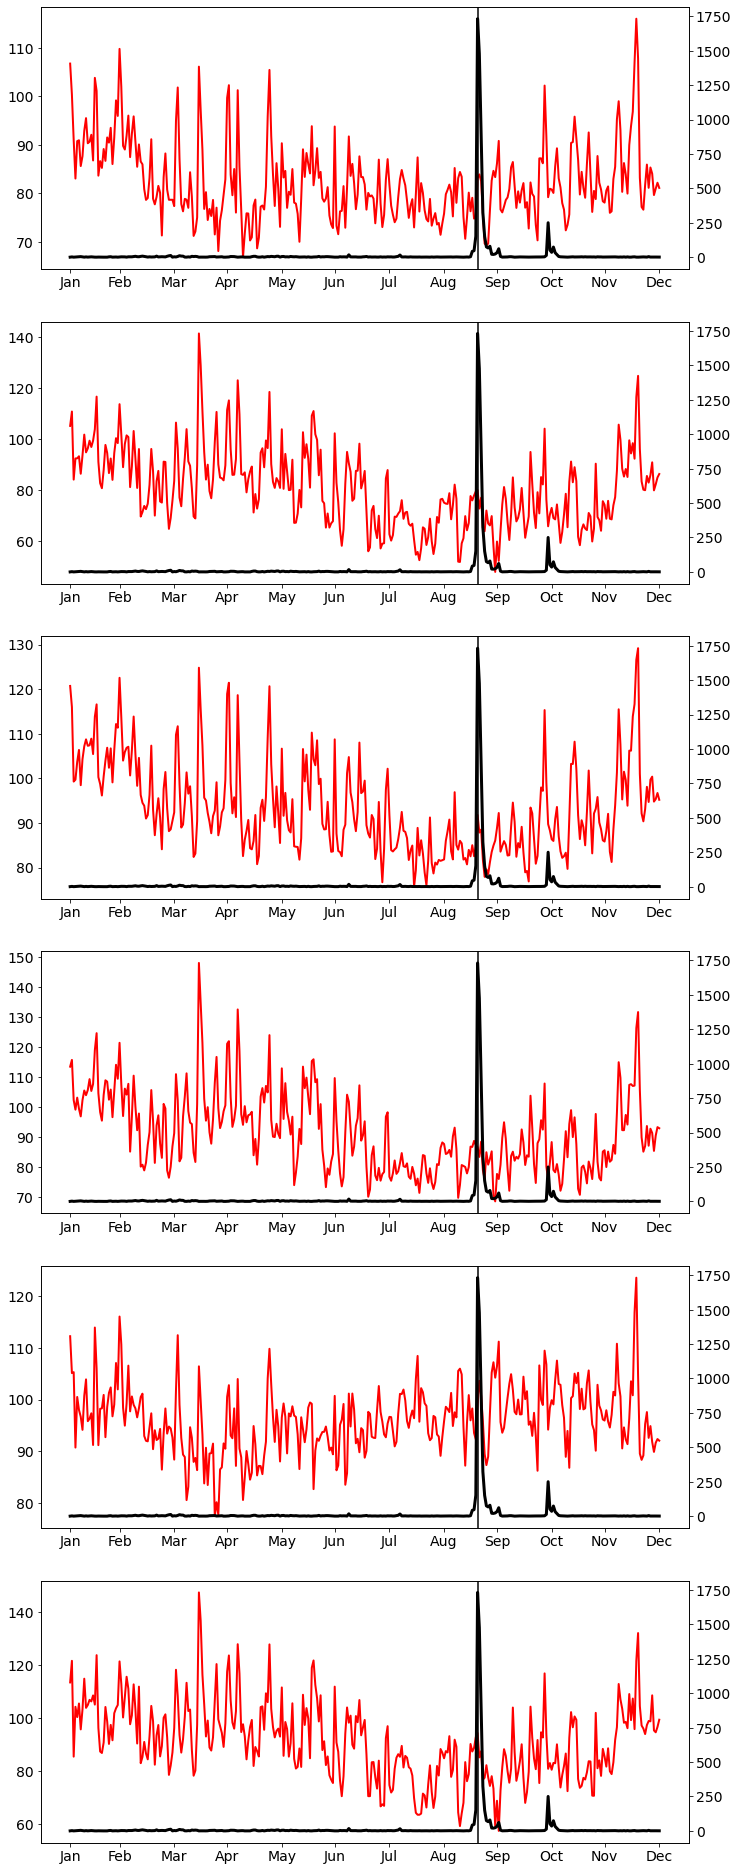

In [107]:
RE=Focus_RE
print(DW_Regions[RE])
ddY = ((IFS_time.year == 2020) & (IFS_time.month > 0))
# EucledianDist_orig = DATA_ED[DW_Regions[RE]]['EucledianDist_orig']
MinWTs = np.argmin(EucledianDist_orig, axis=1)

fig = plt.figure(figsize=(10,EucledianDist_orig.shape[1]*5))

gs2 = gridspec.GridSpec(EucledianDist_orig.shape[1],1)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

MON = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
iMon = np.array([31,59,90,120,151,181,212,243,273,304,334,365])-31

DAYs = np.zeros((365,len(IFSYYYY),EucledianDist_orig.shape[1])); DAYs[:]=np.nan
for wt in range(EucledianDist_orig.shape[1]):
    ax = plt.subplot(gs2[wt,0])
#     for yy in range(len(IFSYYYY)):
#         ddY = (IFS_time.year == IFSYYYY[yy])
#         plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='k', alpha=0.3)
#         try:
#             DAYs[:,yy,wt] = EucledianDist_orig[ddY,wt][:365]
#         except:
#             DAYs[:np.sum(ddY),yy,wt] = EucledianDist_orig[ddY,wt]
    plt.plot(range(365), np.mean(DAYs[:,:-1,wt], axis=1), c='k', alpha=0.5, lw=2)
    plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='r', lw=2)
    plt.xticks(iMon,MON)
    plt.axvline(x=np.sum(iMon[7])+18+1, label='SCU Lightning Complex', c='k')
    
    # Plot burned area for 2020 on 2nd Yaxis
    ax2 = ax.twinx()
    ax2.plot(range(np.sum(ddY)),FIRMSV_SRdata[ddY], c='k', lw=3)
    
    


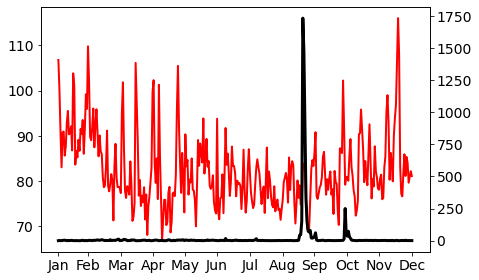

In [108]:
# fig = plt.figure(figsize=(10,5))

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

MON = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
iMon = np.array([31,59,90,120,151,181,212,243,273,304,334,365])-31
ddY = ((IFS_time.year == 2020) & (IFS_time.month > 0))

DAYs = np.zeros((365,len(IFSYYYY),EucledianDist_orig.shape[1])); DAYs[:]=np.nan
wt = 0
ax = plt.subplot(gs2[0,0])


plt.plot(range(365), np.mean(DAYs[:,:-1,wt], axis=1), c='k', alpha=0.5, lw=2)
plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='r', lw=2)
plt.xticks(iMon,MON)

# Plot burned area for 2020 on 2nd Yaxis
ax2 = ax.twinx()
ax2.plot(range(np.sum(ddY)),FIRMSV_SRdata[ddY], c='k', lw=3)
plt.show()

### Plot the Synoptic situation for target days

[0.42089552 0.07761194]


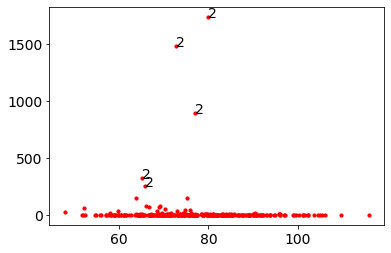

In [109]:
ddY = ((IFS_time.year == 2020) & (IFS_time.month > 0))
plt.scatter(np.min(EucledianDist_orig[ddY,:][:], axis=1), FIRMSV_SRdata[ddY][:], color='r', s = 10)
TOP = np.argsort(FIRMSV_SRdata[ddY][:])[-5:]
for to in range(len(TOP)):
    plt.text(np.min(EucledianDist_orig[ddY,:], axis=1)[TOP[to]], FIRMSV_SRdata[ddY][:][TOP[to]], str(MinWTs[ddY][TOP[to]]+1))

from Functions_Extreme_WTs import ExtremeDays
MinDistDD=7 # two extremes should be at least 7 days appart
iEvents = 2
rgdTime = rgdTimeFIRMS_V[ddY]
rgrPRrecords = FIRMSV_SRdata[ddY]
rgiExtrTrainSel=ExtremeDays(rgrPRrecords, iEvents, MinDistDD)

PeakEvents=rgdTime[rgiExtrTrainSel]

YYYYpeak=np.unique(PeakEvents.year)
ExtremeDay_asll = PeakEvents
RANKS_all = np.zeros((len(ExtremeDay_asll))); RANKS_all[:]=np.nan
SelWTs = np.zeros((len(ExtremeDay_asll))); SelWTs[:]=np.nan
for ev in range(len(ExtremeDay_asll)):
    Day = ExtremeDay_asll[ev]
    DayInYear = Day.timetuple().tm_yday
    ED_extr= EucledianDist_orig[ddY,:][DayInYear-1,:] #    XWT_output['grEucledianDist'][DayInYear-1]
    iRank=np.array([np.where(np.sort(EucledianDist_orig[ddY,ii]) == ED_extr[ii])[0] for ii in range(len(ED_extr))])
    RANKS_all[ev] = np.min((iRank/len(EucledianDist_orig[ddY,:]))*100.)
    SelWTs[ev] = XWTclusters[1][np.argmin((iRank/len(EucledianDist_orig[ddY,:])))] #  SortXWTs[iSORTreg][np.argmin(EucledianDist_orig[ddY,:], axis=1)[DayInYear-1]]
FAR = ((RANKS_all/100.)*sum(ddY))/sum(ddY)
print(FAR)

# plt.scatter(np.min(EucledianDist_orig[ddY,:][1:], axis=1), FIRMSV_SRdata[ddY,RE][:-1], color='k', s = 10)
# plt.scatter(np.min(EucledianDist_orig[ddY,:][:-1], axis=1), FIRMSV_SRdata[ddY,RE][1:])

In [110]:
ExtremeDay_asll

DatetimeIndex(['2020-08-19', '2020-09-28'], dtype='datetime64[ns]', freq=None)

### Read the IFS data for plotting

In [111]:
# Read IFS data directly
rgsWTvarsN=['U850','V850','RH2','Q850','T2AVG','Z500']

if DW_Regions[re] == 'Bay_Area':
    DAYS = [datetime.datetime(2020, 8, 19),datetime.datetime(2020, 9, 28)]
if DW_Regions[re] == 'Siearas_West':
    DAYS = [datetime.datetime(2020, 9, 9),datetime.datetime(2020, 9, 17)]
if DW_Regions[re] == 'LA':
    DAYS = [datetime.datetime(2020, 9, 17),datetime.datetime(2020, 9, 7)]

sf = shp.Reader(sSubregionPR+DW_Regions[RE])
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)



for dd in range(len(DAYS)):
    TargetDay = DAYS[dd]

    DataDirPL = '/gpfs/fs1/collections/rda/data/ds113.1/ec.oper.an.pl/'
    VarsPL = [['V','132_v','V',"850"],
              ['U','131_u','U',"850"],
              ['Q','133_q','Q',"850"],
              ['Z','129_z',"Z","500"]]

    Plevs=['850','500'] #,'200']
    HH = ['00','06','12','18']
    FocusReg = [60,360-86,10,360-150]

    # ________________________________________________________________________
    # ________________________________________________________________________
    #              READ IN THE COORDINATES
    ncid=Dataset('/gpfs/fs1/collections/rda/data/ds113.1/ec.oper.an.pl/202008/ec.oper.an.pl.128_133_q.regn1280sc.2020082418.nc', mode='r')
    rgrLat=np.squeeze(ncid.variables['latitude'][:])
    rgrLon=np.squeeze(ncid.variables['longitude'][:])
    Plev = np.squeeze(ncid.variables['level'][:])
    ncid.close()

    # Find region of interest
    NN = np.where(rgrLat >= FocusReg[0])[0][-1]
    EE = np.where(rgrLon >= FocusReg[1])[0][0]
    SS = np.where(rgrLat <= FocusReg[2])[0][0]
    WW = np.where(rgrLon <= FocusReg[3])[0][-1]

    LAT = rgrLat[NN:SS]
    LON = rgrLon[WW:EE]

    iPL = np.array([np.where(Plev == int(Plevs[pl]))[0][0] for pl in range(len(Plevs))])

    LON[LON>180]=LON[LON>180]-360
    LON2D, LAT2D = np.meshgrid(LON, LAT)

    if dd == 0:
        DATA = np.zeros((len(DAYS), len(LAT), len(LON), len(VarsPL), len(HH))); DATA[:]=np.nan
    for sl in range(len(VarsPL)):
        print('    process '+str(VarsPL[sl][0]))
        sYYYYMM = str(TargetDay.year)+str(TargetDay.month).zfill(2)
        sYYYYMMDD = str(TargetDay.year)+str(TargetDay.month).zfill(2)+str(TargetDay.day).zfill(2)
        print('            '+sYYYYMMDD)
        for hh in range(len(HH)):
            PLact = np.where(Plev == int(VarsPL[sl][3]))[0][0] 
            if ((VarsPL[sl][0] != 'U') & (VarsPL[sl][0] != 'V')):
                DATAfile = DataDirPL+sYYYYMM+'/ec.oper.an.pl.128_'+VarsPL[sl][1]+'.regn1280sc.'+sYYYYMMDD+HH[hh]+'.nc'
            else:
                DATAfile = DataDirPL+sYYYYMM+'/ec.oper.an.pl.128_'+VarsPL[sl][1]+'.regn1280uv.'+sYYYYMMDD+HH[hh]+'.nc'
            ncid=Dataset(DATAfile, mode='r')
            DATA[dd,:,:,sl,hh] = np.squeeze(ncid.variables[VarsPL[sl][2]][:,PLact,NN:SS,WW:EE])
            ncid.close()


    

    process V
            20200819
    process U
            20200819
    process Q
            20200819
    process Z
            20200819
    process V
            20200928
    process U
            20200928
    process Q
            20200928
    process Z
            20200928


### Plot the XWT centroids in ERA5 and ERA-20C

selected day is 2020-08-29 00:00:00
        Plot map to: /glade/u/home/prein/papers/Extreme-WTs-US/plots/IFS_XWTs/Example_IFS-XWT1-Bay_Area.pdf


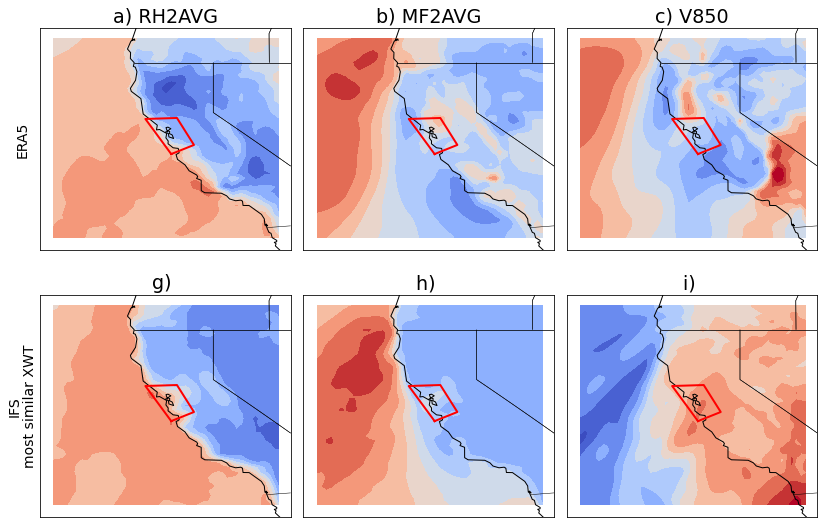

In [112]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
rgsLableABC=list(string.ascii_lowercase)

WTSEL=1
SEL = np.argsort(EucledianDist_orig, axis=0)[0,WTSEL]
print('selected day is '+str(IFS_time[SEL]))

gs2 = gridspec.GridSpec(2,3)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

m = Basemap(projection='cea',\
            llcrnrlat= np.min(IFSLat2D) ,urcrnrlat=np.max(IFSLat2D),\
            llcrnrlon=np.min(IFSLon2D),urcrnrlon=np.max(IFSLon2D),resolution='l', fix_aspect=False)
xi, yi = m(XWTlon,XWTlat)
for va in range(3):
    ax = plt.subplot(gs2[0,va])
    cs1= plt.contourf(xi, yi, Clusters[WTSEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va]+') '+SelVar[re][va])
    if va == 0:
        ax.text(-0.07,0.5, 'ERA5' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=14) #, weight='bold')

# XWT days in ERA-20C
xi, yi = m(XWTlon,XWTlat) #IFSLon2D,IFSLat2D)
NORMED = RemappedIFS-np.mean(RemappedIFS, axis=(1,2))[:,None,None,:]
NORMED = NORMED/np.std(NORMED, axis=(1,2))[:,None,None,:]
for va in range(3):
    ax = plt.subplot(gs2[1,va])
    cs1= plt.contourf(xi, yi, NORMED[SEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va+6]+') ')
    if va == 0:
        ax.text(-0.07,0.5, 'IFS\nmost similar XWT' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=14) #, weight='bold')
        
# # add colorbar for centroids
# CbarAx = axes([0.025, 0.04, 0.95, 0.02])
# cb = colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
# cb.ax.tick_params(labelsize=14)
# cb.ax.set_title('normalized centroids []', fontsize=14)

sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'Example_IFS-XWT'+str(WTSEL)+'-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot the XWT conditions and fire propagation maps from VIRIIS

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-357720.4658490962,-161007.71642995346,-43262.57004110768,109453.49947428377&bboxSR=3310&imageSR=3310&size=500,430&dpi=50&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-357720.4658490962,-161007.71642995346,-43262.57004110768,109453.49947428377&bboxSR=3310&imageSR=3310&size=500,430&dpi=50&format=png32&transparent=true&f=image
        Plot map to: /glade/u/home/prein/papers/Extreme-WTs-US/plots/IFS_XWTs/IFS_large-scale-pattern_Bay_Area-2020-09-28.png


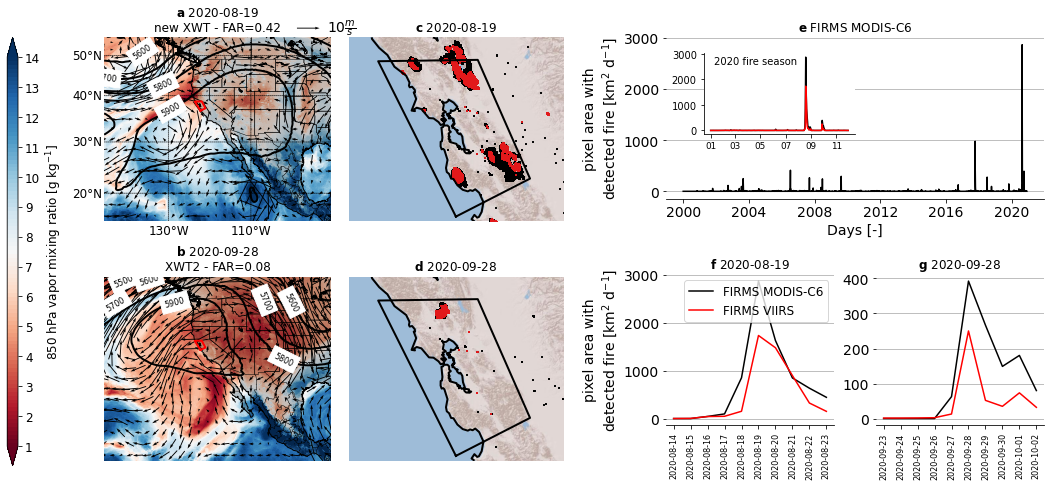

In [113]:
# Calculate the geometry of the plot dependent on how many panels there are
plt.rcParams.update({'font.size': 14})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(15,7))
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.12, right=0.55,
           bottom=0.08, top=0.92,
           wspace=0.05, hspace=0.30)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.

for dd in range(DATA.shape[0]):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    ax = plt.subplot(gs1[dd,0])
    rllcrnrlat=np.mean((LAT2D.min(),LAT2D.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=np.mean((LAT2D.min(),LAT2D.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=np.mean((LON2D.min(),LON2D.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=np.mean((LON2D.min(),LON2D.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
    m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    plt.axis('off')
    xi, yi = m(LON2D, LAT2D)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,100) # np.linspace(1, 14,200)
    rgrDataAct= np.mean(DATA[dd,:,:,2,:], axis=2)*1000 #      DATA[:,:,rgsWTvarsN.index('Q850')]*1000
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=30
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],
                   np.mean(DATA[dd,::iDist,::iDist,1,:], axis=2),
                   np.mean(DATA[dd,::iDist,::iDist,0,:], axis=2),
                   units='width',zorder = 2, pivot='middle',width=0.004, scale=100)
    if dd == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # Plot ZG500
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],
                 np.mean(DATA[dd,:,:,3,:], axis=2)/9.81,
                 levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]

    # Lable the map
    if FAR[dd] > 0.25:
        plt.title(r"$\bf{" + str(rgsLableABC[dd]) + "}$"' '+str(DAYS[dd])[:10]+'\nnew XWT'+' - FAR='+str(np.round(FAR[dd],2)), fontsize=12)
    else:
        plt.title(r"$\bf{" + str(rgsLableABC[dd]) + "}$"' '+str(DAYS[dd])[:10]+'\nXWT'+str(int(SelWTs[dd]+1))+' - FAR='+str(np.round(FAR[dd],2)), fontsize=12)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)

    if dd == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)
            
    # =================================================
    # ADD FIRE PROGRESSION MAP
    ax = plt.subplot(gs1[dd,1])
    plt.axis('off')
    if DW_Regions[re] == 'Bay_Area':
        rllcrnrlat=36.5
        urcrnrlat=39
        llcrnrlon=-124
        urcrnrlon=-120.5
    if DW_Regions[re] == 'Siearas_West':
        rllcrnrlat=34.5
        urcrnrlat=41
        llcrnrlon=-122.5
        urcrnrlon=-116
    m = Basemap(projection='mill',llcrnrlon=llcrnrlon ,llcrnrlat=rllcrnrlat,
        urcrnrlon=urcrnrlon ,urcrnrlat=urcrnrlat, resolution = 'i', epsg = 3310)
    m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, dpi=50, verbose= True)

    m.drawcoastlines(color='k', linewidth=2)
    m.drawcountries(color='k', linewidth=2)
    m.drawstates(color='k', linewidth=2)

    parallels = np.arange(0.,81,5)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
    meridians = np.arange(10.,351.,5)
    m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Plot the subregions
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)
      
    # plot total burned area
    for fd in [-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]:
        iFireDay = ((YYYY_FV == DAYS[dd].year) & (MM_FV == DAYS[dd].month) & (DD_FV == DAYS[dd].day+fd))
        FireLat = LAT_FV[iFireDay]
        FireLon = LON_FV[iFireDay]
        xx, yy = m(FireLon,FireLat)
        plt.scatter(xx,yy, color='k', s=1, marker='s')
    
    iFireDay = ((YYYY_FV == DAYS[dd].year) & (MM_FV == DAYS[dd].month) & (DD_FV == DAYS[dd].day))
    FireLat = LAT_FV[iFireDay]
    FireLon = LON_FV[iFireDay]
    xx, yy = m(FireLon,FireLat)
    plt.scatter(xx,yy, color='#e31a1c', s=1, marker='s')

    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[dd+2]) + "}$ "+str(DAYS[dd])[:10], fontsize=12)
    
# ========================   
# Add the fire time series
from Functions_Extreme_WTs import add_subplot_axes
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.64, right=0.99,
           bottom=0.60, top=0.92,
           wspace=0.05, hspace=0.20)
ax = plt.subplot(gs2[0,0])

plt.plot(rgdTimeFIRMS_M, FIRMSM_SRdata, c='k')
ax.set_xlabel('Days [-]')
ax.set_ylabel('pixel area with\ndetected fire [km$^{2}$ d$^{-1}$]')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis='y')

# Lable the map
plt.title(r"$\bf{" + str(rgsLableABC[4]) + "}$ FIRMS MODIS-C6", fontsize=12)

# plot an inlay for 2020 fire season
rect = [0.1,0.4,0.4,0.5]
ax1 = add_subplot_axes(ax,rect)
# plt.axis('off')
Mday = (rgdTimeFIRMS_M.year == 2020)
Vday = (rgdTimeFIRMS_V.year == 2020)
ax1.plot(rgdTimeFIRMS_M[Mday], FIRMSM_SRdata[Mday], c='k', label='FIRMS MODIS-C6')
ax1.plot(rgdTimeFIRMS_V[Vday], FIRMSV_SRdata[Vday], c='r', label='FIRMS VIIRS')

ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
date_form = DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.text(0.07,0.9, '2020 fire season' , ha='left',va='center', rotation=0, \
                transform = ax1.transAxes, fontname="Times New Roman Bold", fontsize=10) #, weight='bold')# # ax2.yaxis.set_ticks_position('left')


# zoom into the 2020 fire periods
gs3 = gridspec.GridSpec(1,2)
gs3.update(left=0.64, right=0.99,
           bottom=0.15, top=0.45,
           wspace=0.25, hspace=0.20)
deltaDay=5
for fd in range(DATA.shape[0]):
    ax = plt.subplot(gs3[0,fd])
    Mday = np.where(rgdTimeFIRMS_M == DAYS[fd])[0][0]
    Vday = np.where(rgdTimeFIRMS_V == DAYS[fd])[0][0]
    plt.plot(rgdTimeFIRMS_M[Mday-deltaDay:Mday+deltaDay], FIRMSM_SRdata[Mday-deltaDay:Mday+deltaDay], c='k', label='FIRMS MODIS-C6')
    plt.plot(rgdTimeFIRMS_V[Vday-deltaDay:Vday+deltaDay], FIRMSV_SRdata[Vday-deltaDay:Vday+deltaDay], c='r', label='FIRMS VIIRS')
    if fd == 0:
        ax.set_ylabel('pixel area with\ndetected fire [km$^{2}$ d$^{-1}$]')
        plt.legend(fontsize = 12)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(axis='y')
    plt.xticks(rotation=90, fontsize = 8)
    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[5+fd]) + "}$ "+str(DAYS[fd])[:10], fontsize=12)
    
# add colorbar for IVT
CbarAx = axes([0.03, 0.07, 0.01, 0.85])
cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max', ticks=np.arange(1,21,1))
cb.ax.tick_params(labelsize=12)
cb.set_label('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=12)


sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'IFS_large-scale-pattern_'+DW_Regions[RE]+'-'+str(TargetDay)[:10]+'.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [97]:
DAYS

[datetime.datetime(2020, 9, 9, 0, 0), datetime.datetime(2020, 9, 14, 0, 0)]

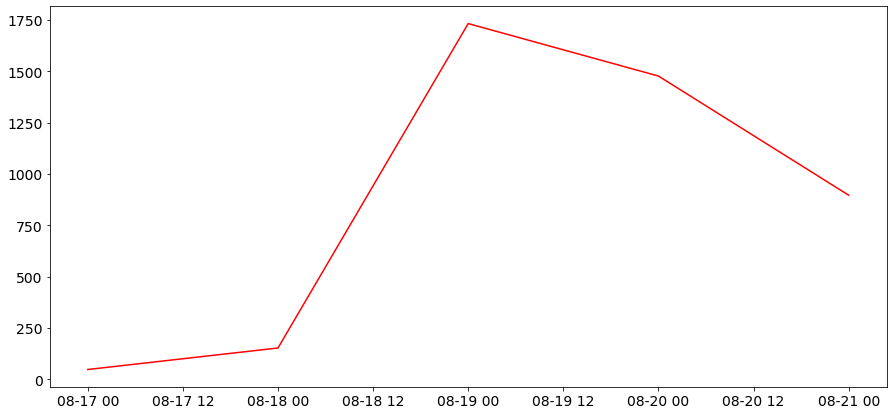

In [17]:
fig = plt.figure(figsize=(15,7))
# Vday = np.where((rgdTimeFIRMS_V.year == 2020) & ((rgdTimeFIRMS_V.month == 8)) & ((rgdTimeFIRMS_V.day == 20)))
# ax1.plot(rgdTimeFIRMS_M[Mday], FIRMSM_SRdata[Mday], c='k', label='FIRMS MODIS-C6')
plt.plot(rgdTimeFIRMS_V[1690:1695], FIRMSV_SRdata[1690:1695], c='r', label='FIRMS VIIRS')

In [20]:
FIRMSV_SRdata[1691]

151.86169999999998

In [22]:
FIRMSV_SRdata[1692]

1732.162

In [23]:
FIRMSV_SRdata[1692]/FIRMSV_SRdata[1691]

11.406180755252972